## Static dataset creation
This notebook walks through how to use the modules to create and save a static dataset for use in all of the statistical and ML methods. The method-focused notebooks show how to import and utilize this static dataset in inference.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data.data import MyDataLoader, DataPreparation

Use the `DataPreparation()` class from `io` to simulate some linear data with two levels of noise.

Low noise is $\sigma = 1$. High noise is $\sigma = 10$. Both use the same input xs and same priors. Let's simulate the low noise first.

In [2]:
data = DataPreparation()

In [3]:
size_df = 1000
noise = 'high'
data.sample_params_from_prior(size_df, 42)

In [4]:
# lookup dict
noise_to_sigma = {
    'low': 1,
    'medium': 5,
    'high': 10,
    'vhigh': 100
}

Select the noise profile. Right now the only option is `linear_homoskedastic`.

In [5]:
noise_profile = 'linear_homoskedastic'

Now select the type of noise injection. Options are 'feature' and 'predictive', where feature injects noise on x and predictive injects directly on y.

In [6]:
inject = 'feature'

In [7]:
data.simulate_data(data.params,
                   noise_to_sigma[noise], 
                   simulation_name = noise_profile,
                   inject_type = inject
                    )

linear_homoskedastic simulation data generated,                 with noise injected type: feature.


Let's take a look at this simulated dataset.

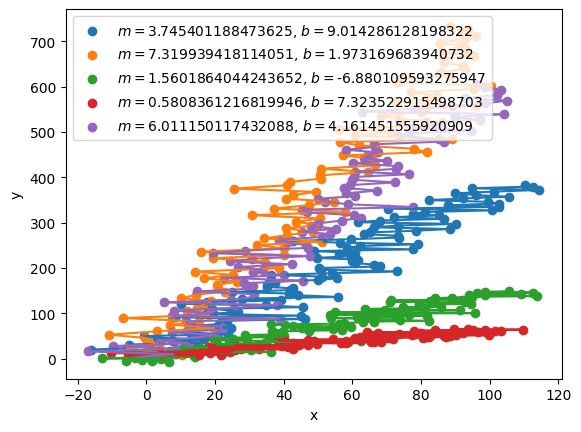

In [8]:
plt.clf()
for i in range(5):
    plt.plot(data.input[i], data.output[i])
    plt.scatter(data.input[i], data.output[i],
                label = f'$m = ${data.params[i][0]}, $b = ${data.params[i][1]}')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()
    

In [9]:
# now make it into a dataframe
dict = data.get_dict()
dict

{'params': array([[ 3.74540119,  9.01428613],
        [ 7.31993942,  1.97316968],
        [ 1.5601864 , -6.88010959],
        ...,
        [ 7.51375086,  3.13910313],
        [ 9.56614621, -8.62083967],
        [ 0.57054721, -4.35625851]]),
 'inputs': tensor([[  4.9671,  14.9936,  -4.7518,  ...,  94.9886, 112.5609, 110.3059],
         [ -1.3826,  10.2463,   0.5548,  ...,  92.0679,  93.5999,  88.4464],
         [  6.4769,   1.5963,  -5.9242,  ..., 112.7013,  98.6911, 105.7544],
         ...,
         [  6.4084,  -7.8187, -10.4176,  ...,  96.5010, 103.0919,  97.4684],
         [ -5.7118,  -0.6307,   5.3418,  ...,  93.4190,  96.8891,  98.5541],
         [  5.7258,  -6.4490,   0.4474,  ...,  93.4610, 100.2006,  88.8304]]),
 'output': tensor([[ 9.0143e+00,  1.2760e+01,  1.6505e+01,  ...,  3.7606e+02,
           3.7981e+02,  3.8355e+02],
         [ 1.9732e+00,  9.2931e+00,  1.6613e+01,  ...,  7.1933e+02,
           7.2665e+02,  7.3397e+02],
         [-6.8801e+00, -5.3199e+00, -3.7597e+00,  .

## Save the data to h5

In [10]:
saver = MyDataLoader()

In [11]:
# save the dataframe
filepath = '../data/'
saver.save_data_h5(f'{noise_profile}_{inject}_sigma_{noise_to_sigma[noise]}_size_{size_df}',
                   dict)

## Save for all noise levels and all inject styles

In [12]:
noise_list = ['low', 'medium', 'high']
inject_list = ['feature', 'predictive']

for noise in noise_list:
    for injection in inject_list:
        data.simulate_data(data.params,
                           noise_to_sigma[noise], 
                           simulation_name = noise_profile,
                           inject_type = injection
                            )
        
        dict = data.get_dict()
        saver.save_data_h5(f'{noise_profile}_{injection}_sigma_{noise_to_sigma[noise]}_size_{size_df}',
                           dict)

linear_homoskedastic simulation data generated,                 with noise injected type: feature.
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
